In [2]:
%load_ext autoreload
%autoreload 2

In [31]:
import logging
from tqdm import trange
from tqdm.contrib.logging import logging_redirect_tqdm
import time

LOG = logging.getLogger(__name__)

logging.basicConfig(level=logging.INFO)
with logging_redirect_tqdm():
    for i in trange(10):
        if i % 2 == 0:
            LOG.info("console logging redirected to `tqdm.write()`")
            time.sleep(1)

INFO:__main__:console logging redirected to `tqdm.write()`
INFO:__main__:console logging redirected to `tqdm.write()`
INFO:__main__:console logging redirected to `tqdm.write()`
INFO:__main__:console logging redirected to `tqdm.write()`
INFO:__main__:console logging redirected to `tqdm.write()`
100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


In [3]:
import pandas as pd
import numpy as np

In [4]:
import sys
sys.path.append("..")
from rlrecs.envs.dataset import DataLoader

In [17]:
rating = np.load("/home/inoue/work/RLRecs/results/envs/YahooR3/rating.npy")
rating

array([[5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 4., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       ...,
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.]], dtype=float32)

In [26]:
for u in range(rating.shape[0]):
    print("user %d rating"%u)
    for i in range(1, 6):
        print("%d:"%i, rating[u, :][rating[u, :] == i].shape[0], end=", ")
    print()

user 0 rating
1: 0, 2: 0, 3: 1, 4: 182, 5: 818, 
user 1 rating
1: 0, 2: 2, 3: 21, 4: 310, 5: 668, 
user 2 rating
1: 0, 2: 0, 3: 3, 4: 79, 5: 919, 
user 3 rating
1: 0, 2: 0, 3: 0, 4: 183, 5: 818, 
user 4 rating
1: 0, 2: 0, 3: 58, 4: 871, 5: 72, 
user 5 rating
1: 0, 2: 5, 3: 55, 4: 651, 5: 290, 
user 6 rating
1: 0, 2: 0, 3: 0, 4: 20, 5: 981, 
user 7 rating
1: 0, 2: 0, 3: 0, 4: 43, 5: 958, 
user 8 rating
1: 0, 2: 0, 3: 8, 4: 190, 5: 803, 
user 9 rating
1: 0, 2: 0, 3: 25, 4: 399, 5: 577, 
user 10 rating
1: 0, 2: 0, 3: 0, 4: 1, 5: 1000, 
user 11 rating
1: 0, 2: 0, 3: 11, 4: 267, 5: 723, 
user 12 rating
1: 0, 2: 0, 3: 1, 4: 62, 5: 938, 
user 13 rating
1: 0, 2: 0, 3: 0, 4: 0, 5: 1001, 
user 14 rating
1: 0, 2: 0, 3: 2, 4: 72, 5: 927, 
user 15 rating
1: 0, 2: 0, 3: 0, 4: 6, 5: 995, 
user 16 rating
1: 0, 2: 0, 3: 0, 4: 52, 5: 949, 
user 17 rating
1: 0, 2: 0, 3: 72, 4: 741, 5: 188, 
user 18 rating
1: 0, 2: 0, 3: 0, 4: 78, 5: 923, 
user 19 rating
1: 0, 2: 0, 3: 0, 4: 13, 5: 988, 
user 20 rating
1:

In [6]:
df = pd.read_csv("/home/inoue/work/dataset/RC15/yoochoose-clicks.dat", header=None, sep=",")
df.columns = ["sessionId", "timestamp", "itemId", "category"]

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3433: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
sessions = df.groupby("sessionId")["itemId"].unique()
sessions

sessionId
1                [214536502, 214536500, 214536506, 214577561]
2           [214662742, 214825110, 214757390, 214757407, 2...
3                           [214716935, 214774687, 214832672]
4                                      [214836765, 214706482]
6                                      [214701242, 214826623]
                                  ...                        
11562156                               [214854802, 214848995]
11562157                               [214580372, 214516012]
11562158                               [214849132, 214854774]
11562159                                          [214849132]
11562161                                          [214546022]
Name: itemId, Length: 9249729, dtype: object

In [13]:
sessions.apply(len).value_counts()

2      3273089
1      2493154
3      1447044
4       748610
5       423918
        ...   
195          1
150          1
185          1
147          1
170          1
Name: itemId, Length: 178, dtype: int64

<AxesSubplot: >

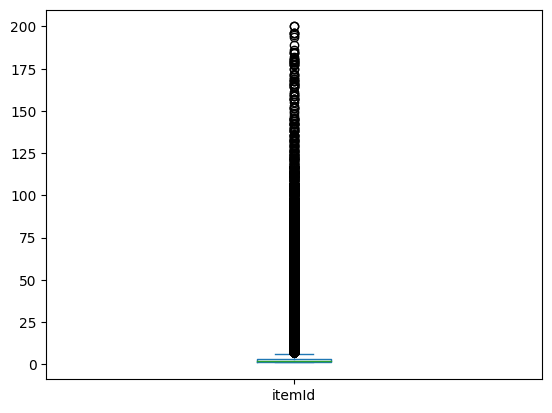

In [12]:
sessions.apply(len).plot(kind="box")

In [9]:
pd.to_datetime(df.loc[:10, "timestamp"], format="%Y-%m-%dT%X.%fZ")a

0    2014-04-07 10:51:09.277
1    2014-04-07 10:54:09.868
2    2014-04-07 10:54:46.998
3    2014-04-07 10:57:00.306
4    2014-04-07 13:56:37.614
5    2014-04-07 13:57:19.373
6    2014-04-07 13:58:37.446
7    2014-04-07 13:59:50.710
8    2014-04-07 14:00:38.247
9    2014-04-07 14:02:36.889
10   2014-04-02 13:17:46.940
Name: timestamp, dtype: datetime64[ns]

In [4]:
df = pd.read_csv("/home/inoue/work/dataset/YahooR3/ydata-ymusic-rating-study-v1_0-train.txt", sep="\t", header=None)
df.columns = ["userId", "itemId", "rating"]
df["itemId"].unique().shape, df["itemId"].max(), df["itemId"].min()

((1000,), 1000, 1)

In [27]:
dataloader = DataLoader(df.values)

In [32]:
count = 0
for batch in dataloader.shuffle().batch(64):
    count += 1
count

4870

In [9]:
df = pd.read_csv("/home/inoue/work/dataset/YahooR3/ydata-ymusic-rating-study-v1_0-test.txt", sep="\t", header=None)
df.columns = ["userId", "itemId", "rating"]
df["itemId"].unique().shape, df["itemId"].max(), df["itemId"].min()

((1000,), 1000, 1)

In [1]:
import jax
from jax import numpy as jnp

In [2]:
a = jnp.arange(40).reshape((-1, 5))
a

DeviceArray([[ 0,  1,  2,  3,  4],
             [ 5,  6,  7,  8,  9],
             [10, 11, 12, 13, 14],
             [15, 16, 17, 18, 19],
             [20, 21, 22, 23, 24],
             [25, 26, 27, 28, 29],
             [30, 31, 32, 33, 34],
             [35, 36, 37, 38, 39]], dtype=int32)

In [5]:
b = jnp.asarray([1, 3, 3, 2, 2, 0, 1, 1])
b

DeviceArray([1, 3, 3, 2, 2, 0, 1, 1], dtype=int32)

In [9]:
jax

DeviceArray([[ 1,  3,  3,  2,  2,  0,  1,  1],
             [ 6,  8,  8,  7,  7,  5,  6,  6],
             [11, 13, 13, 12, 12, 10, 11, 11],
             [16, 18, 18, 17, 17, 15, 16, 16],
             [21, 23, 23, 22, 22, 20, 21, 21],
             [26, 28, 28, 27, 27, 25, 26, 26],
             [31, 33, 33, 32, 32, 30, 31, 31],
             [36, 38, 38, 37, 37, 35, 36, 36]], dtype=int32)